<a href="https://colab.research.google.com/github/leahmashi/DL_HW1/blob/main/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Deep learning workshop 1



In [1]:
# installs
!pip install split-folders
!pip install lightning>=2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# imports 
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import datasets
from collections import Counter 
import splitfolders
import lightning as L
import torch.nn.functional as F
from torchmetrics import Accuracy

## Getting the images from kaggle

In [3]:
# connecting to local file system to upload authorization file (for downloading from kaggle)
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! kaggle datasets download -d lantian773030/pokemonclassification

 99% 414M/417M [00:10<00:00, 41.8MB/s]
100% 417M/417M [00:11<00:00, 39.5MB/s]


In [6]:
# ! rm -r /content/PokemonData
!unzip /content/pokemonclassification.zip

Streaming output truncated to the last 5000 lines.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  
  inflating: PokemonData/G

## Explore the data

### Creating the dataset

In [44]:
BATCH_SIZE = 16

splitfolders.ratio('/content/PokemonData', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

train_set = datasets.ImageFolder("/content/output/train", transform=torchvision.transforms.ToTensor())
test_set = datasets.ImageFolder("/content/output/test", transform=torchvision.transforms.ToTensor())
validation_set = datasets.ImageFolder("/content/output/val", transform=torchvision.transforms.ToTensor())
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)


### Extracting metadata from dataset

In [8]:
# size of dataset
len(imagenet_data)

6820

In [9]:
# sample the data
x0, y0 = imagenet_data[0]
print("1st sample: ", x0.shape)

x1, y1 = imagenet_data[1]
print("2nd sample: ", x1.shape)

1st sample:  torch.Size([3, 220, 229])
2nd sample:  torch.Size([3, 422, 422])


From the cell above we can see that all pictures have 3 channels (red, green and blue)\
but the dimensions are different. Therefore we need to preprocess the images by resizing them:


In [45]:
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))
train_set = datasets.ImageFolder("/content/output/train", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))
test_set = datasets.ImageFolder("/content/output/test", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))
validation_set = datasets.ImageFolder("/content/output/val", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# size of dataset
print("dataset size: ", len(imagenet_data))

# sample the data
x0, y0 = imagenet_data[0]
print("check the pictures are from the same dimensions: ")
print("1st sample: ", x0.shape)

x1, y1 = imagenet_data[1]
print("2nd sample: ", x1.shape)

# number of classes
print("number of classes: ", len(imagenet_data.classes))

# number of examples per class
counts = dict(Counter(imagenet_data.targets))
labels = imagenet_data.class_to_idx
y_dictionary = {label : counts[labels[label]] for label  in labels}
print(y_dictionary)

dataset size:  6820
check the pictures are from the same dimensions: 
1st sample:  torch.Size([3, 256, 256])
2nd sample:  torch.Size([3, 256, 256])
number of classes:  150
{'Abra': 35, 'Aerodactyl': 35, 'Alakazam': 26, 'Alolan Sandslash': 41, 'Arbok': 41, 'Arcanine': 41, 'Articuno': 45, 'Beedrill': 34, 'Bellsprout': 40, 'Blastoise': 42, 'Bulbasaur': 41, 'Butterfree': 27, 'Caterpie': 37, 'Chansey': 43, 'Charizard': 35, 'Charmander': 51, 'Charmeleon': 46, 'Clefable': 38, 'Clefairy': 46, 'Cloyster': 48, 'Cubone': 40, 'Dewgong': 43, 'Diglett': 39, 'Ditto': 40, 'Dodrio': 39, 'Doduo': 35, 'Dragonair': 42, 'Dragonite': 48, 'Dratini': 26, 'Drowzee': 39, 'Dugtrio': 51, 'Eevee': 37, 'Ekans': 35, 'Electabuzz': 41, 'Electrode': 51, 'Exeggcute': 46, 'Exeggutor': 50, 'Farfetchd': 48, 'Fearow': 48, 'Flareon': 45, 'Gastly': 44, 'Gengar': 49, 'Geodude': 35, 'Gloom': 49, 'Golbat': 48, 'Goldeen': 47, 'Golduck': 46, 'Golem': 46, 'Graveler': 39, 'Grimer': 44, 'Growlithe': 44, 'Gyarados': 46, 'Haunter': 48,

we can see from the cell above that the data is unbalanced

### handle unbalanced data?

### Train-Test-Validation split

In [12]:
# train, test = torch.utils.data.random_split(imagenet_data, [0.8, 0.2], torch.Generator().manual_seed(42))

In [6]:
X_train = np.array([np.array(train_set[i][0]) for i in range(len(train_set))])
print("X_train: ", X_train.shape)

y_train = np.array([np.array(train_set[i][1]) for i in range(len(train_set))])
print("y_train: ", y_train.shape)

X_train:  (5391, 3, 256, 256)
y_train:  (5391,)


In [7]:
X_test = np.array([np.array(test_set[i][0]) for i in range(len(test_set))])
print("X_test: ", X_test.shape)

y_test = np.array([np.array(test_set[i][1]) for i in range(len(test_set))])
print("y_test: ", y_test.shape)

X_test:  (814, 3, 256, 256)
y_test:  (814,)


In [8]:
X_valid = np.array([np.array(validation_set[i][0]) for i in range(len(validation_set))])
print("X_valid: ", X_valid.shape)

y_valid = np.array([np.array(validation_set[i][1]) for i in range(len(validation_set))])
print("y_valid: ", y_valid.shape)

X_valid:  (615, 3, 256, 256)
y_valid:  (615,)


our data consists of 5391 training samples, 814 test samples and 615 validation samples

### Augmentation?

### Benchmark results?

### Samples of each label

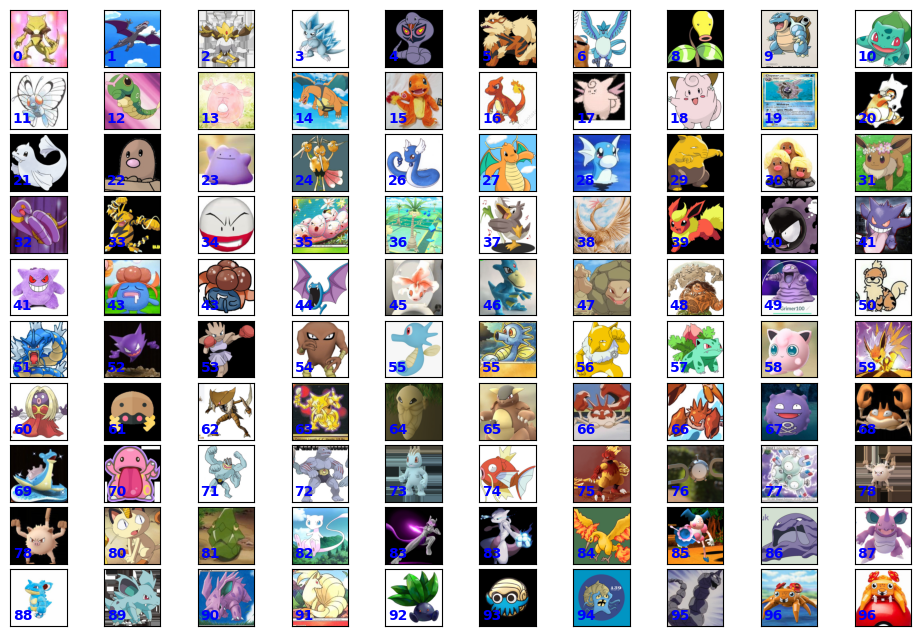

In [16]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i].swapaxes(0,1).swapaxes(1,2).squeeze(),cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        skip += 33
    plt.show()
plot_multiple_imgs(X_train,y_train,10,10,(12,8))

we can see it's hard to differenciate between:  
*   15 and 16
*   22 and 30
*   66 and 68
*   0 and 2 and 63
*   71 and 72 and 73
*   85 and 87






## KFold cross validation

In [46]:
data_path = ""

class CNN_Pokemon(L.LightningModule):
    def __init__(self, data_dir=data_path, num_classes=150, learning_rate=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3,32,3,padding='same') 
        ## input channels 3 for rgb 
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv2 = nn.Conv2d(32,64,3,padding='same')
        self.conv3 = nn.Conv2d(64,32,3,padding='same')
        self.conv4 = nn.Conv2d(32,64,3,padding='same')
        self.linear1 = nn.Linear(64*64*64,50)
        self.linear2 = nn.Linear(50,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=150)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=150)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp(x)
        x = self.flatten(x)
        # x = x.view(-1,256*256*64)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx): 
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    # def prepare_data(self):
    #     # download
    #     datasets.MNIST(self.data_dir, train=True, download=True)
    #     datasets.MNIST(self.data_dir, train=False, download=True)

    # def setup(self, stage=None):
    #     # Assign train/val datasets for use in dataloaders
    #     if stage == "fit" or stage is None:
    #         mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
    #         self.mnist_train, self.mnist_val = random_split(mnist_full, [50000, 10000])

    #     # Assign test dataset for use in dataloader(s)
    #     if stage == "test" or stage is None:
    #         self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

In [ ]:
pokemon_model = CNN_Pokemon()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=20,
)
trainer.fit(pokemon_model)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name          | Type               | Params
------------------------------------------------------
0  | conv1         | Conv2d             | 896   
1  | conv2         | Conv2d             | 18.5 K
2  | conv3         | Conv2d             | 18.5 K
3  | conv4         | Conv2d             | 18.5 K
4  | linear1       | Linear             | 13.1 M
5  | linear2 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
pokemon_model

In [43]:
trainer.test()

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_28/checkpoints/epoch=4-step=845.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_28/checkpoints/epoch=4-step=845.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_28/checkpoints/epoch=4-step=845.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_28/checkpoints/epoch=4-step=845.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.07160081714391708    │
│         test_loss         │     4.112922191619873     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.112922191619873, 'test_acc': 0.07160081714391708}]